In [1]:
# Load the modules we're going to need
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import glob
import librosa
import pandas as pd# Added
from IPython.display import Audio
from sklearn.externals import joblib

In [2]:
# We've previously preprocessed our data and coverted all files to a sample rate of 44100
samplerate = 44100

In [12]:
# Specify where the audio files for training and testing reside
train_folder = './../exp1/train'
test_folder = './../exp1/test'

# Get a list of all the training audio files (must be .WAV files)
train_files = glob.glob(os.path.join(train_folder, '*.wav'))

# Get a list of all the test audio files (must be .WAV files)
test_files = glob.glob(os.path.join(test_folder, '*.wav'))

# Specify the labels (classes) we're going to classify the data into
label0 = 'abscent'
label1 = 'present'
labels = [label0, label1]

In [4]:
# Make 1 second summarization as features with half second of hop length
# 172 frames == 1 second (using 44100 samples per second)
# 166 frames ~ 0.96 second
feature_length = 96
half_sec = 48

In [5]:
# Define lists to store the training features and corresponding training labels
train_features = []
train_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in train_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load VGGish audio embeddings
    vggish = pd.read_csv(tf[:-7]+"VGGish_PCA.csv",index_col=None, header=None)
    vggish = pd.DataFrame.as_matrix(vggish)
    
    # Read labels for each frame
    f0line = pd.read_csv(tf[:-7]+"vocal.csv",index_col=None, header=None)
    f0line = pd.DataFrame.as_matrix(f0line)
    f0line = f0line.T[0][48:] # VGGish starts from 0.48 second
    
    #print (vggish)
    #print (mfcc.shape)
    #print("number of chunks", int(mfcc.shape[1]/half_sec))
    
    feature_vector = []
    tf_label = []
    
    print (vggish.shape[0]/half_sec)
    
    for chunk in range(vggish.shape[0]): # if hop = 10ms then use: range(int(vggish.shape[0]/half_sec)):
        start = chunk*half_sec
        vggish_means = np.mean(vggish[start:start+1, :], 0) # I removed the smooth to get only one window
        vggish_stddevs = np.std(vggish[start:start+1, :], 0)
        #print (vggish_means.shape, start, start+feature_length)
    
        # Concatenate means and std. dev's into a single feature vector
        #feature_vector.append(np.concatenate((vggish_means, vggish_stddevs), axis=0))
        #print (np.concatenate((vggish_means, vggish_stddevs), axis=0))
        #if hop = 10ms then use:feature_vector.append(vggish[start, :][0])
        feature_vector.append(vggish[chunk, :])
   
        # Adjust labels to our classes
        if len([x for x in f0line[start:start+feature_length] if x > 0]) >= half_sec: # 50%
            tf_label.append('present')
        else:
            tf_label.append('abscent')

    # Get labels index
    tf_label_ind = [labels.index(lbl) for lbl in tf_label]
    print("file label size: {:d}".format(len(tf_label_ind)))
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        train_features.append(feature_vector[idx])
        train_labels.append(tf_label_ind[idx]) 
    print(" ")

In [13]:
# Define lists to store the test features and corresponding test labels
test_features = []
test_labels = []

# For every audio file in the training set, load the file, compute MFCCs, summarize them over time
# using the mean and standard deviation (for each MFCC coefficient), and then save the features
# and corresponding label in the designated lists
for tf in test_files:
    
    print("filename: {:s}".format(os.path.basename(tf)))
    
    # Load VGGish audio embeddings
    vggish = pd.read_csv(tf[:-7]+"VGGish_PCA.csv",index_col=None, header=None)
    vggish = pd.DataFrame.as_matrix(vggish)
    
    # Read labels for each frame
    f0line = pd.read_csv(tf[:-7]+"vocal.csv",index_col=None, header=None)
    f0line = pd.DataFrame.as_matrix(f0line)
    f0line = f0line.T[0][48:] # VGGish starts from 0
    
    #print (mfcc.shape)
    #print("number of chunks", int(mfcc.shape[1]/half_sec))
    
    feature_vector = []
    tf_label = []
    
    print (vggish.shape[0])
    
    for chunk in range(vggish.shape[0]): # if hop = 10ms then use: range(int(vggish.shape[0]/half_sec)):
        start = chunk*half_sec
        vggish_means = np.mean(vggish[start:start+1, :], 0) # I removed the smooth to get only one window
        vggish_stddevs = np.std(vggish[start:start+1, :], 0)
        #print (vggish_means.shape, start, start+feature_length)
    
        # Concatenate means and std. dev's into a single feature vector
        #feature_vector.append(np.concatenate((vggish_means, vggish_stddevs), axis=0))
        #if hop = 10ms then use:feature_vector.append(vggish[start, :][0])
        feature_vector.append(vggish[chunk, :])
        
        #print(feature_vector)
        
        # Adjust labels to our classes
        if len([x for x in f0line[start:start+feature_length] if x > 0]) >= half_sec: # 50%
            tf_label.append('present')
        else:
            tf_label.append('abscent')
    
    #Get labels index
    tf_label_ind = np.array([labels.index(lbl) for lbl in tf_label])
    print("file label size: {}".format(tf_label_ind.shape))
    
    
    # Store the feature vector and corresponding label in integer format
    for idx in range(len(feature_vector)):
        test_features.append(feature_vector[idx])
        test_labels.append(tf_label_ind[idx])
    print(" ")

filename: MusicDelta_Country2_MIX.wav
35
file label size: (35,)
 
filename: MusicDelta_Country1_MIX.wav
71
file label size: (71,)
 
filename: SweetLights_YouLetMeDown_MIX.wav


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


815
file label size: (815,)
 
filename: MusicDelta_Gospel_MIX.wav
156
file label size: (156,)
 
filename: PortStWillow_StayEven_MIX.wav
659
file label size: (659,)
 
filename: StrandOfOaks_Spacestation_MIX.wav
507
file label size: (507,)
 
filename: MusicDelta_Rock_MIX.wav
26
file label size: (26,)
 
filename: InvisibleFamiliars_DisturbingWildlife_MIX.wav
454
file label size: (454,)
 
filename: Snowmine_Curfews_MIX.wav
572
file label size: (572,)
 
filename: CelestialShore_DieForUs_MIX.wav
579
file label size: (579,)
 


In [7]:
# Create a scale object
scaler = sklearn.preprocessing.StandardScaler()

# Learn the parameters from the training data only
scaler.fit(train_features)

# Apply the learned parameters to the training and test sets:
train_features_scaled = scaler.transform(train_features)

In [48]:
test_features_scaled = scaler.transform(test_features)

# Note, the first 2 operations (learning the standardization parameters from the training data 
# and applying them to the the training data) can be performed in one line using:
# train_features_scaled = scaler.fit_transform(train_features)

In [9]:
# save the scaler to disk
filename = 'scaler_VGGish.sav'
joblib.dump(scaler, filename)

['scaler_VGGish.sav']

<h2> Step 3: model training</h2>

Now that all of our features are computed, we can train a clasification model! In this example we're going to use the following model: the support vector machine classifier. 

In [21]:
# Use scikit-learn to train a model with the training features we've extracted

# Lets use a SVC with folowing C parameters: 
params = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

for c in params:
    clf = sklearn.svm.SVC(C=c)

    # Fit (=train) the model
    clf.fit(train_features_scaled, train_labels)
    
    # save the model to disk
    filename = 'finalized_model_SVM_'+str(c)+'_VGGish.sav'
    print (filename)
    joblib.dump(clf, filename)
    
    # Now lets predict the labels of the test data!
    predictions = clf.predict(test_features_scaled)
    
    # We can use sklearn to compute the accuracy score
    accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
    print(accuracy)

finalized_model_SVM_100_VGGish.sav
0.865625508378
finalized_model_SVM_10_VGGish.sav
0.879128029933
finalized_model_SVM_1_VGGish.sav
0.889702293802
finalized_model_SVM_0.1_VGGish.sav
0.891329103628
finalized_model_SVM_0.01_VGGish.sav
0.868553766065
finalized_model_SVM_0.001_VGGish.sav
0.687815194404
finalized_model_SVM_0.0001_VGGish.sav
0.687815194404


In [ ]:
# Use scikit-learn to train a model with the training features we've extracted

# Lets use a SVC with default parameters: kernel RBF 
clf = sklearn.svm.SVC()

# Fit (=train) the model
clf.fit(train_features_scaled, train_labels)

In [11]:
# save the model to disk
filename = 'finalized_model_SVM_'+c+'_VGGish.sav'
joblib.dump(clf, filename)

['finalized_model_VGGish.sav']

In [12]:
# Now lets predict the labels of the test data!
predictions = clf.predict(test_features_scaled)

In [13]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.889702293802


In [18]:
# We can use sklearn to compute the accuracy score BEFORE
ones = np.ones(len(predictions))
accuracy = sklearn.metrics.accuracy_score(test_labels, ones)
print(accuracy)

0.687815194404


In [14]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

[[1568  351]
 [ 327 3901]]


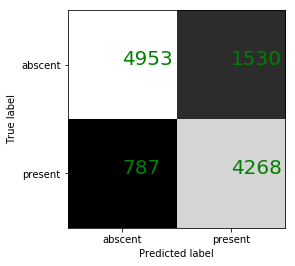

In [21]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

### Random Forest Classifier without scaler

In [44]:
params = [100, 200, 500, 1000]

for estimators in params:
    clf3 = RandomForestClassifier(n_estimators=estimators)

    # Fit (=train) the model
    clf3.fit(train_features, train_labels)
    
    # save the model to disk
    filename = 'finalized_model_RF_'+str(estimators)+'_VGGish.sav'
    print (filename)
    joblib.dump(clf3, filename)
    
    # Now lets predict the labels of the test data!
    predictions = clf3.predict(test_features)
    # We can use sklearn to compute the accuracy score
    accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
    print(accuracy)

finalized_model_RF_100_VGGish.sav
0.884984545307
finalized_model_RF_200_VGGish.sav
0.884008459411
finalized_model_RF_500_VGGish.sav
0.883357735481
finalized_model_RF_1000_VGGish.sav
0.88709939808


In [15]:
from sklearn.ensemble import RandomForestClassifier
clf3 = RandomForestClassifier(n_estimators=500)

# Fit (=train) the model
clf3.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

<h2>Step 4: model evaluation Random Forest Classifier (testing)</h2>

In [16]:
# Now lets predict the labels of the test data!
predictions = clf3.predict(test_features)

<h3>Model accuracy</h3>

In [17]:
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.885472588254


<h3>Confusion matrix</h3>

In [ ]:
# lets compute the show the confusion matrix:
cm = sklearn.metrics.confusion_matrix(test_labels, predictions)
print(cm)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(cm, interpolation='nearest', cmap='gray')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=20, color='green')
ax.set_xticks(range(len(cm)))
ax.set_xticklabels(labels)
ax.set_yticks(range(len(cm)))
ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()

In [11]:
print (test_features)

[]


### Test on test set

In [15]:
# Load scaler (SVM)
filename = '../scaler_VGGish.sav' 
# load the model from disk
scaler = joblib.load(filename)

# Transform data
test_features_scaled = scaler.transform(test_features)

# Load trained model (SVM)
filename = '../finalized_model_SVM_0.1_VGGish.sav' 
# load the model from disk
clf = joblib.load(filename)

# Now lets predict the labels of the test data!
predictions = clf.predict(test_features_scaled)

# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.834796076407


In [49]:
# Load trained model (RF)
filename = 'finalized_model_RF_1000_VGGish.sav' 
# load the model from disk
clf3 = joblib.load(filename)

# Now lets predict the labels of the test data!
predictions = clf3.predict(test_features)
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, predictions)
print(accuracy)

0.830407847186


In [36]:
# Now lets predict the labels of the test data!
ones = np.ones(len(predictions))
# We can use sklearn to compute the accuracy score
accuracy = sklearn.metrics.accuracy_score(test_labels, ones)
print(accuracy)

0.715023231802
